# Projective Transformation

This code implements a function to apply rotations and projective transformations, and to find the transformation matrix given lists of matching points.

## Image Rotation 

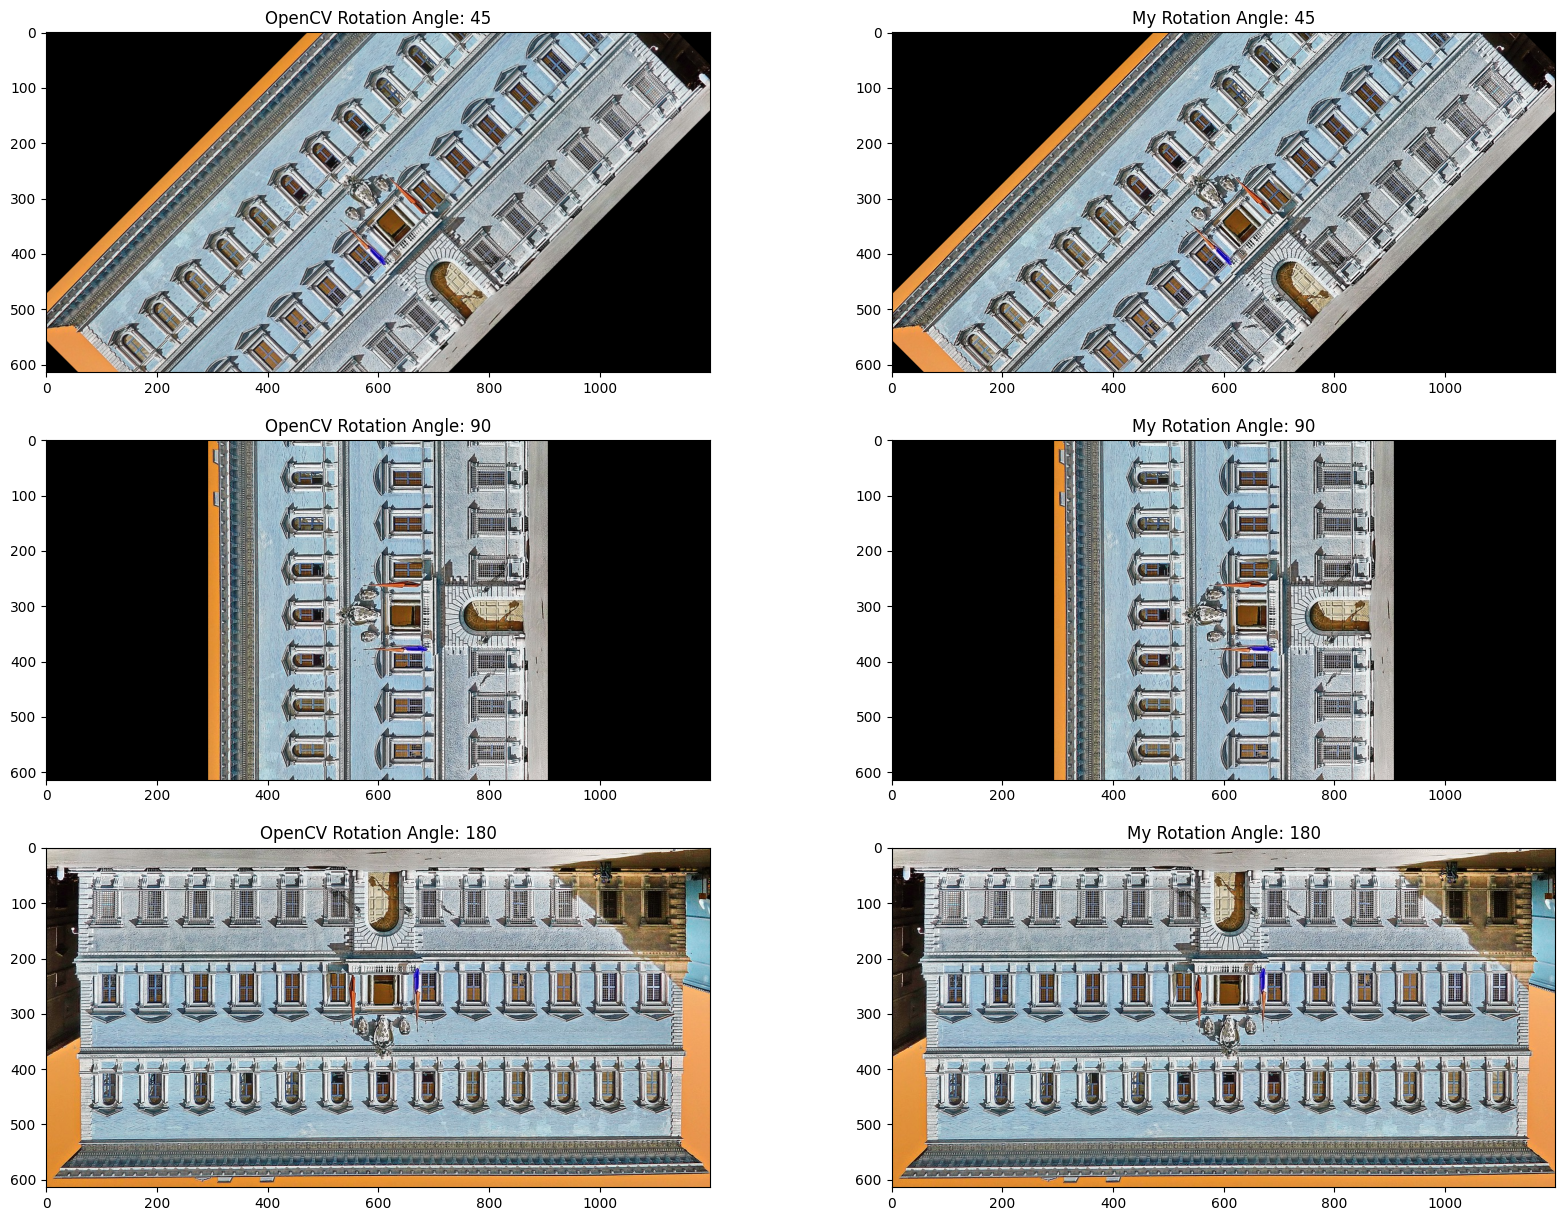

In [13]:
import cv2 as cv
import sys
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread('img/Palazzo_Farnese_Fassade.jpg')
height, width = img.shape[:2]
center = (width/2, height/2)

def my_rotation(img, angle, center):
    """
    Rotate an image by a given angle around a specified center point.

    Args:
        img (numpy.ndarray): The input image to be rotated.
        angle (float): The rotation angle in degrees.
        center (tuple): The center point (x, y) around which the image will be rotated.

    Returns:
        numpy.ndarray: The rotated image.

    """
    
    # The first translation matrix changes the origin of the coordinates from the image corner to the image center.
    matriz_translacao = np.matrix([[1, 0, -center[1]],
                                   [0, 1, -center[0]],
                                   [0, 0, 1]])
    
    angle_rad = np.radians(angle)
    
    # The rotation matrix applies the rotation around the origin.
    matriz_rotacao = np.matrix([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                                [np.sin(angle_rad),  np.cos(angle_rad), 0],
                                [0, 0, 1]])
    
    # (Change the origin), rotate, and then revert to the previous origin.
    matriz_composicao = matriz_translacao.I @ matriz_rotacao @ matriz_translacao
    
    # Create a black rotated image with the same dimensions as the original.
    height, width = img.shape[:2]
    rotated_image = np.zeros((height, width, 3), np.uint8)
    
    # The next step is to go through each pixel of the new image and check which corresponding pixel in the original image.
    m_comp_inv = matriz_composicao.I

    for linr in range(height):
        for colr in range(width):
            pos_rot = np.matrix([linr, colr, 1]).T
            pos_orig = m_comp_inv @ pos_rot

            lin = round(pos_orig[0, 0])
            col = round(pos_orig[1, 0])

            if (lin >= 0 and lin < height) and (col >= 0 and col < width):
                rotated_image[linr, colr] = img[lin, col]
    
    return rotated_image

# Comparison of OpenCV rotation and my_rotation function:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

for linha, angle in enumerate([45, 90, 180]):
    M = cv.getRotationMatrix2D(center, angle, 1)
    rotated_img = cv.warpAffine(img, M, (width, height))

    axs[linha, 0].imshow(rotated_img)
    axs[linha, 0].set_title(f"OpenCV Rotation Angle: {angle}")

    my_rotated = my_rotation(img, angle, center)
    axs[linha, 1].imshow(my_rotated)
    axs[linha, 1].set_title(f"My Rotation Angle: {angle}")

## Apply the Transformation, Given the Projective Matrix T

Text(0.5, 1.0, 'My Transform')

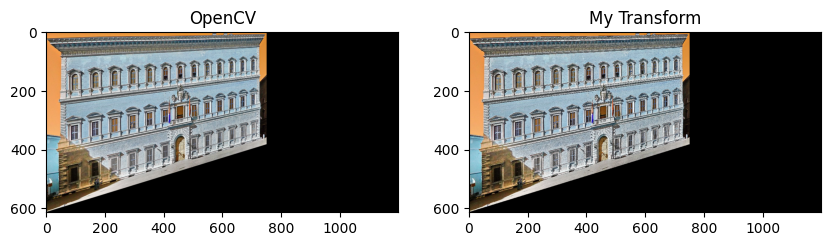

In [15]:
def apply_transformation(img, T):
    """
    Applies a projective transformation to an image.

    Args:
        img (numpy.ndarray): The input image.
        T (numpy.matrix): The transformation matrix.

    Returns:
        numpy.ndarray: The transformed image.
    """

    height, width = img.shape[:2]  # Get the dimensions of the image (height and width)
    transform_image = np.zeros((height, width, 3), np.uint8)  # Create an empty image with the same dimensions

    T_inv = T.I  # Calculate the inverse of the transformation matrix T

    # Iterate over each pixel in the transformed image
    for linr in range(height):
        for colr in range(width):

            trans_point = np.matrix([colr, linr, 1]).T  # Create a column vector for the current point (homogeneous coordinates)

            pos_orig = T_inv @ trans_point  # Apply the inverse transformation to get the original position
            
            if pos_orig.item(-1) != 0:  # Check if the homogeneous coordinate is not zero
                pos_orig = pos_orig / pos_orig.item(-1)  # Normalize the coordinates
            
            col = round(pos_orig[0, 0])  # Get the x-coordinate of the original position
            lin = round(pos_orig[1, 0])  # Get the y-coordinate of the original position

            # Check if the original position is within the bounds of the image
            if (lin >= 0 and lin < height) and (col >= 0 and col < width):
                transform_image[linr, colr] = img[lin, col]  # Assign the pixel value from the original image to the transformed image

    return transform_image  # Return the transformed image


def openCV_transformation(img, T):
    rows, cols = img.shape[:2]
    return cv.warpPerspective(img, T, (cols, rows))

# Define a projective matrix
T = np.matrix([
    [1, 0, 0],
    [0, 1, 0],
    [1/2000, 0, 1]
])

# Compare the implementation of the projective transformation with OpenCV
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(openCV_transformation(img, T))
axs[0].set_title(f"OpenCV")

apply_transformationed = apply_transformation(img, T)
axs[1].imshow(apply_transformationed)
axs[1].set_title(f"My Transform")

## Estimate the Projective Transformation Given Two Lists of Matching Points

The function `estimate_transformation` estimate the projection 4 matching points. To ilustrate it, I mapped the soccer field from the Vasco vs. Flamengo game image into a top-down view using it.

Text(0.5, 1.0, 'Field')

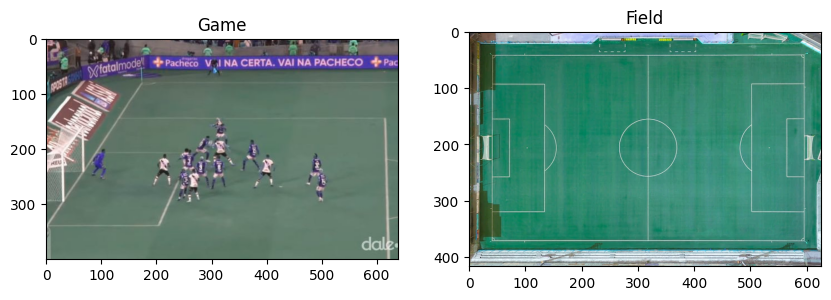

In [20]:
game = cv.imread('img/Vasco_Flamengo.jpg')
field = cv.imread('img/Campo_Futebol.webp')

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(game)
axs[0].set_title(f"Game")

axs[1].imshow(field)
axs[1].set_title(f"Field")

After mapping the points, we find the projective transformation matrix using the function bellow. Finally, we use the `apply_transformation`: 

estimate_transformation:
 [[ 5.62232697e+00 -8.21584525e-01 -1.96251670e+01]
 [ 3.39700804e-01  8.07448489e-01  3.23874877e+01]
 [ 1.41508133e-03 -1.38092375e-03  1.00000000e+00]] 

OpenCV:
 [[ 5.62232697e+00 -8.21584525e-01 -1.96251670e+01]
 [ 3.39700804e-01  8.07448489e-01  3.23874877e+01]
 [ 1.41508133e-03 -1.38092375e-03  1.00000000e+00]] 



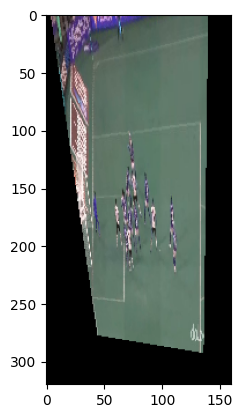

In [16]:
import numpy as np
import matplotlib.pylab as plt

def estimate_transformation(lst1, lst2):
    """
    Estimates the projective transformation matrix H given two sets of corresponding points.

    Parameters:
    lst1 (list): List of source points (x, y).
    lst2 (list): List of destination points (x', y').

    Returns:
    np.matrix: The projective transformation matrix H.

    Raises:
    AssertionError: If the length of lst1 is not equal to 4.

    """
    assert len(lst1) == 4  # The function receives 4 source points

    x, y = [i[0] for i in lst1], [i[1] for i in lst1]
    x_, y_ = [i[0] for i in lst2], [i[1] for i in lst2]

    # Rewrite the system as Ah = b, where h is the vector with the elements of H
    A = np.zeros((9, 9))
    j = 0
    for i in range(4):  # For each pair of source and destination points
        A[j, :] = np.array([-x[i], -y[i], -1, 0, 0, 0, x[i]*x_[i], y[i]*x_[i], x_[i]])
        A[j+1, :] = np.array([0, 0, 0, -x[i], -y[i], -1, x[i]*y_[i], y[i]*y_[i], y_[i]])
        j += 2

    A[8, 8] = 1  # h9 = 1
    b = [0]*8 + [1]  # b is the vector of zeros with 1 at the last position

    H = np.reshape(np.linalg.solve(A, b), (3, 3))  # H is the solution of the system, in 3x3 form

    return np.matrix(H)

# Use manually selected points to estimate the transformation matrix
field_points = [[40, 158], [40, 42], [133, 247], [133, 94]]
game_points = [[90, 207], [171, 80], [620, 327], [615, 145]]

# Compare with the OpenCV solution
print('estimate_transformation:\n', estimate_transformation(field_points, game_points), '\n')
open_cv_trans, _ = cv.findHomography(np.float64(field_points), np.float64(game_points))
print('OpenCV:\n', open_cv_trans, '\n')

H = estimate_transformation(game_points, field_points)

campo_trans = apply_transformation(jogo, np.matrix(H))
plt.imshow(campo_trans[:320, :160])
